In [13]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import viscid
from viscid.plot import vpyplot as vlt
import numpy as np
#import seaborn as sns
viscid.calculator.evaluator.enabled = True

matplotlib.rcParams['figure.figsize'] = (8, 8)

import scipy.constants as constants
mu0 = constants.mu_0
eps0 = constants.epsilon_0
mi = constants.proton_mass
me = constants.electron_mass
c = constants.c
e = constants.e
kB = constants.k
Bfact = 2 # 1/B0 where B0 is initial asymptotic B
Efact = 2/0.223607 # 1/(Va*B0) 
JEfact = 40 # based on using n0 as initial sheet density
Tifact = 1/0.00173959 # 1/T0 (T0 is initial background ion temp)
#matplotlib.style.use('ggplot')
#%config InlineBackend.figure_format = 'retina'

In [14]:
 #Point to directory with the data 
project_dir1="~/UNH/data_m100/"  # 100 mass ratio
project_dir4="~/UNH/data_m400/"  # 400 mass ratio

# Point to single .xdmf file within directory for sim data 
run1 = project_dir1+"/pfd.xdmf"  # mi/me = 100
run4 = project_dir4+"/pfd.xdmf"  # mi/me = 400

vf = viscid.load_file(run4, force_reload=True)


In [15]:
def make_plot(time, run, fldnames=["jy"], **kwargs):
    fig, ax = plt.subplots(len(fldnames), 1, figsize=(1.3*20,1.3*2*len(fldnames)))
    if not isinstance(ax, np.ndarray): ax = [ax]
    for i, fldname in enumerate(fldnames):
        # Hack around some inconsistencies with the field naming
        if run.endswith(".vpc"):
            map = {
                "bx_fc": "Magnetic Field X",
                "by_fc": "Magnetic Field Y",
                "bz_fc": "Magnetic Field Z",
                "jx": "Free Current Field X",
                "jy": "Free Current Field Y",
                
                "jz": "Free Current Field Z",
                "rho_nc": "Charge Density",
                "qn_nc_e": "Charge Density (ehydro)",
                "qn_nc_i": "Charge Density (Hhydro)",
                "jy_nc_e": "Current Density (ehydro) Y",
            }
        else:
            map = {
                "bx_fc": "hx_fc",
                "by_fc": "hy_fc",
                "bz_fc": "hz_fc",
                "qn_nc_e": "rho_nc_e",
                "qn_nc_i": "rho_nc_i",
            }
        vf = viscid.load_file(run, force_reload=True)
        vf.activate_time(time)
        _fldname = map[fldname] if fldname in map else fldname
        mid_val = 0
        
        vlt.plot(vf[_fldname], ax=ax[i], **kwargs);
        #plt.scatter(371, 0, color = 'k')
        #plt.scatter(280,0,color = 'k')
        #plt.xticks(fontsize=10)
        #vlt.plot(vf["psi"],style="contour",levels=300,colors='k', ax=ax[i], **kwargs);






# Convenient plotting fuction
def plot(time, run, fldnames=["jy"], **kwargs):
    fig, ax = plt.subplots(len(fldnames), 1, figsize=(10,3.5*len(fldnames)))
    #if not isinstance(ax, np.ndarray): ax = [ax]
    for i, fldname in enumerate(fldnames):

        vf = viscid.load_file(run, force_reload=True)
        vf.activate_time(time)
        
        vlt.plot(vf[fldname], ax=ax[i], **kwargs);
        plt.xlabel(' ')
        plt.ylabel(' ')
        plt.xticks(fontsize = 13)
        plt.yticks(fontsize = 13)


        
# I honestly forget why this is here
pt = np.array([0, 5, 350])

# Change based on which run you're using 100
xl = np.array([0,-5,-100]) #where are these values for harris_run?  For now I've assumed theyre half the domain (except x)
xh = xl + np.array([800,10,200])
gdims = np.array([5120,1,1280])
dx = (xh - xl) / gdims

# 400
#pt = np.array([0, 5, 350])
#xl = np.array([0,-10,-200])
#xh = xl + np.array([1600,20,400])
#gdims = np.array([10240,1,2560])
#dx = (xh - xl) / gdims


#  Field interpolation (useful for getting fld value at a chosen coordinate)      
def interp(a, pt):
    n = ((pt - xl)/dx).astype(int)
    return a[n[0],n[1],n[2]]

               
# Gets E and B fields at a chosen coordinate
def Get_Fields(r):
    Ex, Ey, Ez = vf['ex_ec'], vf['ey_ec'], vf['ez_ec']
    Bx, By, Bz = vf['hx_fc'], vf['hy_fc'], vf['hz_fc']
    
    
    r = np.array([r[0],0,r[2]]) # Resets the y position to zero (2D sim so fields don't vary along y)
    Ex = interp(Ex,r)
    Ey = interp(Ey,r)
    Ez = interp(Ez,r)
    Bx = interp(Bx,r)
    By = interp(By,r)
    Bz = interp(Bz,r)
    
    E = np.array([Ex, Ey, Ez])
    B = np.array([Bx, By, Bz])
    
    return E, B


# Boris Push.  Returns particle r, p, kinetic energy (k) at each step
def Push(r0,p0,n):
    #Define position (r) & momentum (p) 
    r = np.zeros((n+1,3))
    p = np.zeros((n+1,3))
    k = np.zeros((n+1,1))

    #Initial r & p 
    r[0] = r0
    p[0] = p0
    k[0] = np.linalg.norm(p0)**2 / 2*m

    
    #for i in range(n):
    i=0
    while i<n:

            E, B = Get_Fields(r[i])

            # Convenient rotation vector 
            b_rot = q*B*dt/2*m

            # 1st half of electric push
            p_1 = p[i] + q*E*dt/2

            # Rotation by VxB
            #p_2 = p_1 + 2*VxB((p_1 + VxB(p_1,b_rot))/(1+np.linalg.norm(b_rot)**2),b_rot)
            p_2 = p_1 + 2*np.cross((p_1 + np.cross(p_1, b_rot))/(1+np.linalg.norm(b_rot)**2),b_rot)

            # 2nd half of electric push 
            p[i+1] = p_2 + q*E*dt/2
            r[i+1] = r[i] + p[i+1]*dt/m
            k[i+1] = np.linalg.norm(p[i+1])**2 / 2*m
            i+=1
    
    
    
    
    return r,p,k





pts1 = [371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,369,367,365,363,359,357,358,358,360,370,376,380,388,395,399,400]
# Right now this is specific to the mms_Kg211 run being used
def Em_Evolve(pts, run):
    t = 0
    vf = viscid.load_file(run, force_reload=True)
    var = np.zeros([31,2])
    while t<31:
        vf.activate_time(t)
        E,B = Get_Fields(np.array([pts[t],0,0]))
        var[t] = [t,E[1]] 
        
        t += 1
        
    return var


def make_vec(a,b,c):
    fld = viscid.empty(a.crds,nr_comps=3)
    
    fld['x'] = a
    fld['y'] = b
    fld['z'] = c
    
    fld = fld['y=0j']
    
    return fld



def Activate(run, time):
    vf = viscid.load_file(run, force_reload=True)
    t = time
    vf.activate_time(t)
    a = vf["hx_fc"]
    x,y,z = a.crds.get_crds_nc()
    dx,dy,dz = a.crds.get_dx()
        
    # E&B Fields
    Ex, Ey, Ez = vf["ex_ec"], vf["ey_ec"], vf["ez_ec"] 
    Bx, By, Bz = vf["hx_fc"], vf["hy_fc"], vf["hz_fc"]
    E = make_vec(Ex,Ey,Ez)
    B = make_vec(Bx,By,Bz)

    B_mag = (Bx**2 + By**2 + Bz**2)**0.5
    E_mag = (Ex**2 + Ey**2 + Ez**2)**0.5

    EPar = (Ex*Bx + Ey*By * Ez*Bz) / B_mag
    EPerp = E_mag - EPar

    # Current densities
    jx_e, jy_e, jz_e = vf["jx_nc_e"], vf["jy_nc_e"], vf["jz_nc_e"]
    jx_i, jy_i, jz_i = vf["jx_nc_i"], vf["jy_nc_i"], vf["jz_nc_i"]
    je = make_vec(jx_e,jy_e,jz_e)
    ji = make_vec(jx_i,jy_i,jz_i)

    J_mag = ((jx_e + jx_i)**2 + (jy_e + jy_i)**2 + (jz_e + jz_i)**2)**0.5
    Je_mag = (jx_e**2 + jy_e**2 + jz_e**2)**0.5

    JPar = ((jx_e+jx_i)*Bx + (jy_e+jy_i)*By + (jz_e+jz_i)*Bz)/B_mag
    #JPerp = J_mag - JPar
    JePar = (jx_e*Bx + jy_e*By + jz_e*Bz)/B_mag
    #JePerp = Je_mag - JePar

    # Velocities
    vex = jx_e / vf["rho_nc_e"]
    vey = jy_e / vf["rho_nc_e"]
    vez = jz_e / vf["rho_nc_e"]
    vix = jx_i / vf["rho_nc_i"]
    viy = jy_i / vf["rho_nc_i"]
    viz = jz_i / vf["rho_nc_i"]
    ve = make_vec(vex,vey,vez)
    vi = make_vec(vix,viy,viz)

    # Non-ideal E Fields
    Ex_prime = Ex  + vey*Bz - vez*By
    Ey_prime = Ey  + vez*Bx - vex*Bz
    Ez_prime = Ez  + vex*By - vey*Bx
    E_prime = make_vec(Ex_prime, Ey_prime, Ez_prime)

    # Field Energy Densities (not sure what to put as factor, so can't compare magnitudes)
    uE = (Ex**2 + Ey**2 + Ez**2)/2
    uB = (Bx**2 + By**2 + Bz**2)/2
        # ## Maybe 

    # Number densities (related to charge density parameter)
    ne, ni = vf["ne = -rho_nc_e"], vf["ni = rho_nc_i"]

    nq = "nq = rho_nc_e + rho_nc_i"

    # Temperatures
    # Divide by three?  or no?
    Tex, Tey, Tez = vf["txx_nc_e"], vf["tyy_nc_e"], vf["tzz_nc_e"]
    Tix, Tiy, Tiz = vf["txx_nc_i"], vf["tyy_nc_i"], vf["tzz_nc_i"]

    Tee = make_vec(Tex, Tey, Tez) #  IMPORTANT NOTE: These are not really vector components...
    Tii = make_vec(Tix, Tiy, Tiz) #           .....they are diagonal terms in temp tensors

    Te = (vf["txx_nc_e"] + vf["tyy_nc_e"] + vf["tzz_nc_e"])/3
    Ti = (vf["txx_nc_i"] + vf["tyy_nc_i"] + vf["tzz_nc_i"])/3

    Te_Par = (Tex*(Bx**2) +Tey*(By**2) + Tez*(Bz**2)) / (Bx**2 + By**2 + Bz**2) 
    Ti_Par = (Tix*(Bx**2) +Tiy*(By**2) + Tiz*(Bz**2)) / (Bx**2 + By**2 + Bz**2) 
    Te_Perp = Te - Te_Par 
    Ti_Perp = Ti - Ti_Par 


    # Poynting Flux
    Sx = (Ey*Bz - Ez*By)#/mu0
    Sy = (Ez*Bx - Ex*Bz)#/mu0
    Sz = (Ex*By - Ey*Bx)#/mu0
    S = make_vec(Sx,Sy,Sz)


    # Kinetic Energy Flux
    #
    #
    #

    # J.E Contributions
    JEx = (jx_e + jx_i)*Ex
    JEy = (jy_e + jy_i)*Ey
    JEz = (jz_e + jz_i)*Ez
    JE = JEx + JEy + JEz

    JEe = jx_e*Ex + jy_e*Ey + jz_e*Ez
    
    #Poynting's Theorem Terms
    divS = (Sx[2:,:,1:-1] - Sx[:-2,:,1:-1]) / (2*dx[0])  + (Sz[1:-1,:,2:] - Sz[1:-1,:,:-2]) / (2*dz[0])
    JdE = (JEx[1:-1,:,1:-1]) + (JEy[1:-1,:,1:-1]) + (JEz[1:-1,:,1:-1])
    #JE_alt = JEx + JEy + JEz
    dudt = -JdE - divS
    


    return E, B, S, ve, E_prime, dudt, ne


In [16]:
pts1 = [371,371,371,371,371,371,371,371,371,371,371,371,372,371,370,369,367,365,363,359,357,358,358,360,370,376,380,388,395,399,400]
pts4 = [783,783,783,783,783,783,783,783,783,780,780,780,780,780,780,780,778,776,774,775,775,775,775,775,775,775]

pts_rg = [371,371,371,371,371,371,371,371,371,371,371,371,372,371,370,368,367,365,363,359,357,358,358,360,370,376,380,388,395,399,400]

pts_sm = [400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,399,399,399,399,399,399]

pts1alt = [375,375,375,375,375,375,375,375,375,375,379,376,373,371,370,368,367,365,363,359,357,358,358,360,370,376,380,388,395,399,400]
#pts1111 = [371,371,371,371,371,371,371,371,371,371,n10,371,372,371,370,369,367,365,363,359,357,358,358,360,370,376,380,388,395,399,400]
#pts1alt2 = [400,400,395,395,395,395,395,395,395,395,379,376,373,371,370,368,367,365,363,359,357,358,358,360,370,376,380,388,395,399,400]


In [75]:



# Initial time in simulation

m,q,dt,n = 1,-1,0.02,10000
t = 18
vf.activate_time(t)


# Define init params for the push
# Define central x,y,z coord
x1 = 380
y1 = 0
z1 = 5


# Initialize central particle position & momentum
r0 = np.array([x1,y1,z1]) 
p0 = np.array([0,0,0]) 

# Initialize the remaining 4 particles for a diamond formation, define their separation from central coord
r,p,k = Push(r0, p0, n)



In [76]:
n=10000
E = np.zeros((n+1,3))
B = np.zeros((n+1,3))
pp = np.zeros((n+1,1))
kp = np.zeros((n+1,1))

for i in range(len(p)):
    E[i], B[i] = Get_Fields(r[i])
    pp[i] = (np.dot(p[i],B[i])**2)/(B[i,0]**2 + B[i,1]**2 + B[i,2]**2)
    kp[i] = np.linalg.norm(pp[i])/2*m

Text(0, 0.5, 'z [de]')

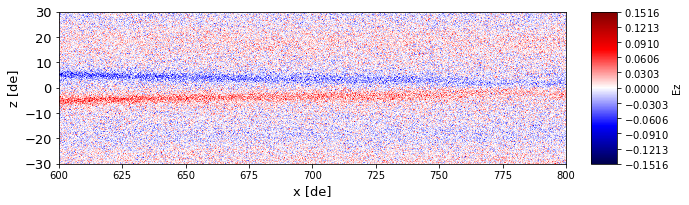

In [23]:

t = 11

vf.activate_time(t)

# E&B Fields
Ex, Ey, Ez = vf["ex_ec"], vf["ey_ec"], vf["ez_ec"] 
Bx, By, Bz = vf["hx_fc"], vf["hy_fc"], vf["hz_fc"]
#E = Efact*make_vec(Ex,Ey,Ez)
E = make_vec(Ex,Ey,Ez)

B = make_vec(Bx,By,Bz)

B_mag = (Bx**2 + By**2 + Bz**2)**0.5
E_mag = (Ex**2 + Ey**2 + Ez**2)**0.5

EPar = (Ex*Bx + Ey*By * Ez*Bz) / B_mag
EPerp = E_mag - EPar

# Current densities
jx_e, jy_e, jz_e = vf["jx_nc_e"], vf["jy_nc_e"], vf["jz_nc_e"]
jx_i, jy_i, jz_i = vf["jx_nc_i"], vf["jy_nc_i"], vf["jz_nc_i"]
je = make_vec(jx_e,jy_e,jz_e)
ji = make_vec(jx_i,jy_i,jz_i)

JePar = (jx_e*Bx + jy_e*By + jz_e*Bz)/B_mag
JiPar = (jx_i*Bx + jy_i*By + jz_i*Bz)/B_mag


J_mag = ((jx_e + jx_i)**2 + (jy_e + jy_i)**2 + (jz_e + jz_i)**2)**0.5
Je_mag = (jx_e**2 + jy_e**2 + jz_e**2)**0.5

JedotE = jx_e*Ex + jy_e*Ey + jz_e*Ez
JidotE = jx_i*Ex + jy_i*Ey + jz_i*Ez

JedotE_Par = JePar*EPar
JidotE_Par = JiPar*EPar

JedotE_Perp = JedotE - JePar*EPar
JidotE_Perp = JidotE - JiPar*EPar



JPar = ((jx_e+jx_i)*Bx + (jy_e+jy_i)*By + (jz_e+jz_i)*Bz)/B_mag
#JPerp = J_mag - JPar

#JePerp = Je_mag - JePar

# Velocities
vex = jx_e / vf["rho_nc_e"]
vey = jy_e / vf["rho_nc_e"]
vez = jz_e / vf["rho_nc_e"]
vix = jx_i / vf["rho_nc_i"]
viy = jy_i / vf["rho_nc_i"]
viz = jz_i / vf["rho_nc_i"]
ve = make_vec(vex,vey,vez)
vi = make_vec(vix,viy,viz)

# Non-ideal E Fields
Ex_prime = Ex  + vey*Bz - vez*By
Ey_prime = Ey  + vez*Bx - vex*Bz
Ez_prime = Ez  + vex*By - vey*Bx
E_prime = make_vec(Ex_prime, Ey_prime, Ez_prime)

JE_prime = (je['x']+ji['x'])*E_prime['x'] + (je['y']+ji['y'])*E_prime['y'] + (je['z']+ji['z'])*E_prime['z'] 
#JE_prime = (je['x'])*E_prime['x'] + (je['y'])*E_prime['y'] + (je['z'])*E_prime['z'] 

# Field Energy Densities (not sure what to put as factor, so can't compare magnitudes)
uE = (Ex**2 + Ey**2 + Ez**2)/2
uB = (Bx**2 + By**2 + Bz**2)/2
    # ## Maybe 

# Number densities (related to charge density parameter)
ne, ni = vf["ne = -rho_nc_e"], vf["ni = rho_nc_i"]

nq = "nq = rho_nc_e + rho_nc_i"

    
uke = ne*(vex**2 + vey**2 + vez**2)/2
    

# Temperatures
# Divide by three?  or no?
Texx, Teyy, Tezz, Texy, Texz, Teyz = vf["txx_nc_e"], vf["tyy_nc_e"], vf["tzz_nc_e"], vf["txy_nc_e"], vf["tzx_nc_e"], vf["tyz_nc_e"]
Tixx, Tiyy, Tizz, Tixy, Tixz, Tiyz = vf["txx_nc_i"], vf["tyy_nc_i"], vf["tzz_nc_i"], vf["txy_nc_i"], vf["tzx_nc_i"], vf["tyz_nc_i"]

Tee = make_vec(Texx, Teyy, Tezz) #  IMPORTANT NOTE: These are not really vector components...
Tii = make_vec(Tixx, Tiyy, Tizz) #           .....they are diagonal terms in temp tensors

Te = (vf["txx_nc_e"] + vf["tyy_nc_e"] + vf["tzz_nc_e"])/3
Ti = (vf["txx_nc_i"] + vf["tyy_nc_i"] + vf["tzz_nc_i"])/3

#Careful when calculating T_Perp.  You'll get negative vals if the factor of 1/3 is only on Te

Te_Par = (Texx*(Bx**2) +Teyy*(By**2) + Tezz*(Bz**2) + 2*Texy*Bx*By + 2*Texz*Bx*Bz + 2*Teyz*By*Bz) / B_mag**2 
Te_Perp = (Texx + Teyy + Tezz - Te_Par)/2 
Te_ParPerp = Te_Par/Te_Perp - 1

Ti_Par = (Tixx*(Bx**2) +Tiyy*(By**2) + Tizz*(Bz**2) + 2*Tixy*Bx*By + 2*Tixz*Bx*Bz + 2*Tiyz*By*Bz) / B_mag**2 
Ti_Perp = (Tixx + Tiyy + Tizz - Ti_Par)/2 
Ti_ParPerp = Ti_Par/Ti_Perp - 1












# Poynting Flux
Sx = (Ey*Bz - Ez*By)#/mu0
Sy = (Ez*Bx - Ex*Bz)#/mu0
Sz = (Ex*By - Ey*Bx)#/mu0
#S = Efact*Bfact*make_vec(Sx,Sy,Sz)
S = make_vec(Sx,Sy,Sz)




# Kinetic Energy Flux
#
#
 #

 # J.E Contributions
JEx = (jx_e + jx_i)*Ex
JEy = (jy_e + jy_i)*Ey
JEz = (jz_e + jz_i)*Ez
JE = JEx + JEy + JEz

JEe = jx_e*Ex + jy_e*Ey + jz_e*Ez
JEi = jx_i*Ex + jy_i*Ey + jz_i*Ez


end = 10000
plt.figure(figsize=(10,10))
plt.subplot(1,1,1)
fld = "Ez = 8.944263820005634*ez_ec"
#fld = JEy

#fld = "ndiff = rho_nc_i + rho_nc_e"
vlt.plot(vf[fld], cmap = "seismic", symmetric = "True")
#plt.plot(r[0:end,0],r[0:end,2], color = 'black')
#plt.scatter(r[3300,0],r[3300,2],marker='o',s=50, c='g')
#plt.scatter(r[4800,0],r[4800,2],marker='o',s=50, c='r')

plt.axis("image")
plt.xlim(600,800)
plt.ylim(-30,30)
#plt.xticks(fontsize = 12)
plt.yticks(fontsize = 13)
#plt.xticks(np.arange(372,386, 4),fontsize=13)

plt.xlabel('x [de]', fontsize=13)
plt.ylabel('z [de]', fontsize=13)



In [153]:
Efact

8.944263820005634

(array([-2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

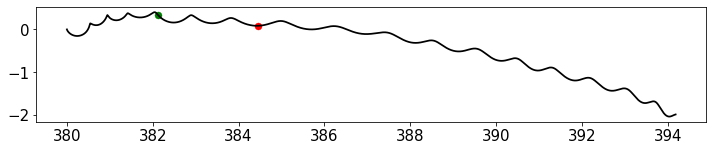

In [78]:
t = 18

vf.activate_time(t)
end = 10000
plt.figure(figsize=(12,12))
plt.subplot(1,1,1)
fld = "jy_nc_e"
#vlt.plot(vf[fld], cmap = "seismic", symmetric = "True")
plt.plot(r[0:end,0],r[0:end,1], color = 'black')
plt.scatter(r[3300,0],r[3300,1],marker='o',s=50, c='g')
plt.scatter(r[4800,0],r[4800,1],marker='o',s=50, c='r')

plt.axis("image")
#plt.xlim(300,410)
#plt.ylim(-20,20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

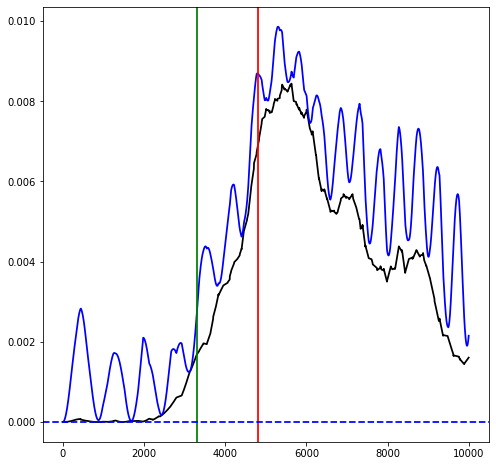

In [81]:
plt.plot(kp[0:end], color = 'black')  #The parallel energy is greater than the total.  Something is wrong...
plt.plot(k[0:end], color = 'b')  #The parallel energy is greater than the total.  Something is wrong...
#plt.plot(kp[0:end]/k[0:end], color = 'g')  #The parallel energy is greater than the total.  Something is wrong...


plt.axvline(x = 3300, color = 'g', label = ' ')
plt.axvline(x = 4800, color = 'r', label = ' ')

#plt.axhline(y = 1, color = 'b',linestyle='--', label = ' ')
plt.axhline(y = 0, color = 'b',linestyle='--', label = ' ')

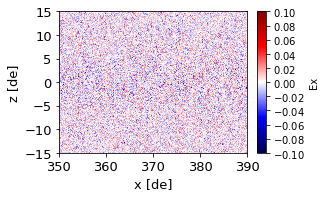

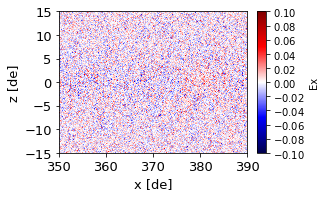

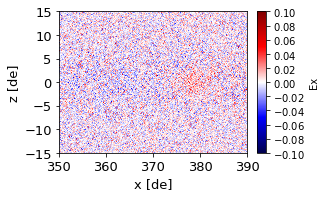

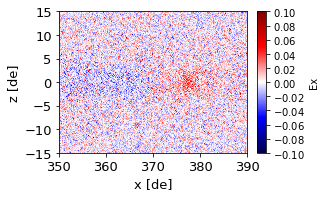

In [38]:

#Trillian Runs

run = run1

t = 10
selection = "x=350f:390f, z=-15f:15f"
#selection = "x=690f:850f, z=-50f:50f"

EyPrime_e = "Ey' = 8.944*ey_ec + 8.944*(jz_nc_e * hx_fc)/rho_nc_e - 8.944*(jx_nc_e * hz_fc)/rho_nc_e "
ExPrime_e = "Ex' = ex_ec + (jy_nc_e * hz_fc)/rho_nc_e - (jz_nc_e * hy_fc)/rho_nc_e "
EzPrime_e = "Ez' = ez_ec + (jx_nc_e * hy_fc)/rho_nc_e - (jy_nc_e * hx_fc)/rho_nc_e "

Ex = "Ex = 8.944*ex_ec"
Ey = "Ey = 8.944*ey_ec"
Ez = "Ez = 8.944*ez_ec"


ne = "ne = -rho_nc_e"
ni = "ni = rho_nc_i"
nimne = "ni-ne = rho_nc_i + rho_nc_e"
nione = "n_ratio = -rho_nc_i/rho_nc_e - 1"
uB = "uB = hx_fc**2 + hy_fc**2 + hz_fc**2"
uE = "uB = ex_ec**2 + ey_ec**2 + ez_ec**2"

JEe = "JEe = 0*jx_nc_e*ex_ec + jy_nc_e*ey_ec + 0*jz_nc_e*ez_ec"






fnt = 13

while t < 14:
    #make_plot(t, run, [ne],cmap = 'seismic',clim=(0,0.017),symmetric=True, selection = selection)
    #make_plot(t, run, [nimne],cmap = 'seismic',clim=(0,0.05),symmetric=True, selection = selection)
    #plt.title(t)

    #make_plot(t, run, [ne],cmap = 'OrRd',symmetric=False, selection = selection)
    make_plot(t, run, [Ex],clim=(0,0.1),cmap = 'seismic',symmetric=True, selection = selection)

    #plt.scatter(pts1[t], 0, color = 'k', s = 50)
    plt.xlabel("x [de]", fontsize=fnt)
    plt.ylabel("z [de]", fontsize=fnt)
    plt.xticks(fontsize=fnt)
    plt.yticks(fontsize=fnt)

    
    #plt.scatter(pts1[t], 0, color = 'g', s = 30)
    #plt.scatter(pts1alt[t], 0, color = 'k', s = 17)
    #plt.scatter(pts1alt[t]+1, 0, color = 'k', s = 17)
    #plt.scatter(pts1alt[t]-1, 0, color = 'k', s = 17)


    t+=1
    

In [6]:
t = 10
make_plot(t, run, ["ex_ec"],cmap = 'seismic',symmetric=True, selection = selection)


NameError: name 'run' is not defined

In [539]:
#Evaluates the terms in Poynting's theorem at different coordinates for each timestep so we can follow the EDR as the xline evolves

pts1 = [371,371,371,371,371,371,371,371,371,371,371,371,372,371,370,369,367,365,363,359,357,358,358,360,370,376,380,388,395,399,400]

endrun1 = 30
endrun4 = 19

endrun = endrun1
pts = pts1alt
run = run1

def Evolve(pts, run):
    ERx = [None]*endrun
    dERx = [None]*endrun
    
    JdotE = [None]*endrun
    div_S = [None]*endrun
    div_T = [None]*endrun

    div_Sx = [None]*endrun
    div_Sz = [None]*endrun

    du_dt = [None]*endrun
    
    for t in range(endrun):
        
        vf = viscid.load_file(run, force_reload=True)
        vf.activate_time(t)
        a = vf["hx_fc"]
        x, y, z = a.crds.get_crds_nc()

        # E&B Fields
        #Ex, Ey, Ez = Efact*vf["ex_ec"], Efact*vf["ey_ec"], Efact*vf["ez_ec"] 
        Ex, Ey, Ez = vf["ex_ec"], vf["ey_ec"], vf["ez_ec"] 

        #Bx, By, Bz = Bfact*vf["hx_fc"], Bfact*vf["hy_fc"], Bfact*vf["hz_fc"]
        Bx, By, Bz = vf["hx_fc"], vf["hy_fc"], vf["hz_fc"]

        # Current densities
        jx_e, jy_e, jz_e = vf["jx_nc_e"], vf["jy_nc_e"], vf["jz_nc_e"]
        jx_i, jy_i, jz_i = vf["jx_nc_i"], vf["jy_nc_i"], vf["jz_nc_i"]
        
        Tex, Tey, Tez = vf["txx_nc_e"], vf["tyy_nc_e"], vf["tzz_nc_e"]
        Tix, Tiy, Tiz = vf["txx_nc_i"], vf["tyy_nc_i"], vf["tzz_nc_i"]

        
        # Velocities
        vex = jx_e / vf["rho_nc_e"]
        vey = jy_e / vf["rho_nc_e"]
        vez = jz_e / vf["rho_nc_e"]
        vix = jx_i / vf["rho_nc_i"]
        viy = jy_i / vf["rho_nc_i"]
        viz = jz_i / vf["rho_nc_i"]


        # Non-ideal E Fields
        Ex_prime = Ex  + vey*Bz - vez*By
        Ey_prime = Ey  + vez*Bx - vex*Bz
        Ez_prime = Ez  + vex*By - vey*Bx
        
        # Poynting Flux
        Sx = (Ey*Bz - Ez*By)#/mu0
        Sy = (Ez*Bx - Ex*Bz)#/mu0
        Sz = (Ex*By - Ey*Bx)#/mu0
        S = make_vec(Sx,Sy,Sz)
        
        # J.E Contributions
        JEx = (0*jx_e + jx_i)*Ex
        JEy = (0*jy_e + jy_i)*Ey
        JEz = (0*jz_e + jz_i)*Ez
        
        ne, ni = vf["ne = -rho_nc_e"], vf["ni = rho_nc_i"]
        ukex = ne*(vex**3)/2
        ukez = ne*(vez**3)/2
    
        
        dx, dy, dz = a.crds.get_dx()
        
        # Poynting's Theorem Terms
        dsx = (Sx[2:,:,1:-1] - Sx[:-2,:,1:-1]) / (2*dx[0])
        dsz = (Sz[1:-1,:,2:] - Sz[1:-1,:,:-2]) / (2*dz[0])
        
        
       
        dtx = (ukex[2:,:,1:-1] - ukex[:-2,:,1:-1]) / (2*dx[0])
        dtz = (ukez[1:-1,:,2:] - ukez[1:-1,:,:-2]) / (2*dz[0])

        divS = dsx + dsz
        divT = dtx + dtz 
        
        JE = (JEx[1:-1,:,1:-1]) + (JEy[1:-1,:,1:-1]) + (JEz[1:-1,:,1:-1])
        dudt = -JE - divS
        
        #spatial averaging (ignore for now.  EDR quantities stable enough for time analysis)
        dsl = viscid.interp(divS, np.array([pts[t] - 1,0,0])) # measurement to the left
        dsr = viscid.interp(divS, np.array([pts[t] + 1,0,0])) # measurement to the right
        JEl = viscid.interp(JE, np.array([pts[t] - 1,0,0])) # measurement to the left
        JEr = viscid.interp(JE, np.array([pts[t] + 1,0,0])) # measurement to the right
        dul = viscid.interp(dudt, np.array([pts[t] - 1,0,0])) # measurement to the left
        dur = viscid.interp(dudt, np.array([pts[t] + 1,0,0])) # measurement to the right
        lft = viscid.interp(Ey_prime, np.array([pts[t] - 1,0,0])) # measurement to the left
        rgt = viscid.interp(Ey_prime, np.array([pts[t] + 1,0,0])) # measurement to the right
        #####
        div_T[t] = viscid.interp(divT, np.array([pts[t],0,0]))#/3
        div_S[t] = viscid.interp(divS, np.array([pts[t],0,0]))#/3
        div_Sx[t] = viscid.interp(dsx, np.array([pts[t],0,0]))#/3
        div_Sz[t] = viscid.interp(dsz, np.array([pts[t],0,0]))#/3
        
        #JdotE[t] = viscid.interp(JE, np.array([pts[t],0,0]))#/3
        #du_dt[t] = viscid.interp(dudt, np.array([pts[t],0,0]))#/3
        #ERx[t] = (viscid.interp(Ey_prime, np.array([pts[t],0,0])))#/3
        
        JdotE[t] = viscid.interp(JE+JEl+JEr, np.array([pts[t],0,0]))/3
        div_S[t] = viscid.interp(divS+dsl+dsr, np.array([pts[t],0,0]))/3
        du_dt[t] = viscid.interp(dudt, np.array([pts[t],0,0]))#/3
        ERx[t] = (viscid.interp(Ey_prime+lft+rgt, np.array([pts[t],0,0])))/3


        


    # Quick way to change time evolving variables from an array of viscid variables to standard values.  Should look identical on a plot
    # Doing this so it is easier to handle calculations of time evolving variables, derivatives, etc.
    ERxx, JdotEE, div_SS, du_dtt, div_Sxx, div_Szz, div_TT = [],[],[],[],[],[], []
    for i in range(endrun):
        ERxx.append(Efact*ERx[i] - 0)  # no idea why the minus zero is whats needed, but it works.
        JdotEE.append(JdotE[i] - 0)
        div_SS.append(div_S[i] - 0)
        div_TT.append(div_T[i] - 0)
        du_dtt.append(du_dt[i] - 0)
        div_Sxx.append(div_Sx[i] - 0)
        div_Szz.append(div_Sz[i] - 0)

    ERx = ERxx
    JdotE = JdotEE
    div_S = div_SS
    div_T = div_TT
    du_dt = du_dtt
    div_Sx = div_Sxx
    div_Sz = div_Szz
        
    
    
    return ERx, JdotE, div_S, div_T, du_dt#, dERx


ERx, JdotE, div_S, div_T, du_dt = Evolve(pts, run)







(array([-0.04, -0.02,  0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,
         0.14]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

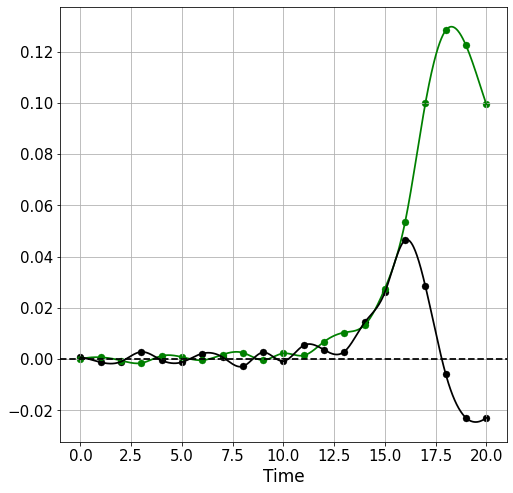

In [540]:
from scipy.interpolate import make_interp_spline
start = 0
stop  = 21
times = list(range(start,stop))
#plt.plot(times, np.abs(ERx[10:]), marker = 'o')
plt.figure(figsize=(8,8))


    
# Interpolating in between points for smoother line
X_Y_Spline = make_interp_spline(times,ERx[start:stop])
X_ = np.linspace(np.min(times), np.max(times), 1000)
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_, color = 'g', label = 'Er (smoothed)')



#Derivative
a = np.diff(ERx[start:stop])/np.diff(times)
a = np.append(a, a[len(a)-1])

X_Y_Spline = make_interp_spline(times,a)
X_ = np.linspace(np.min(times), np.max(times), 1000)
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_, color = 'k', label = ' ')
plt.scatter(times, a, color = 'k', label = 'dEr/dt')
plt.axhline(y = 0, color = 'k', linestyle = '--')#, label = 'upstream B0')









plt.scatter(times, ERx[start:stop], marker = 'o', color = 'g', label = 'Er (measured)')
plt.yscale('linear')
plt.grid(True)
plt.xlabel('Time', fontsize = 17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.ylabel('E Rx', fontsize=17)
#plt.legend(loc='upper left', prop={'size': 18})

In [419]:
JE_fact = JEfact
JdotEnew = []
JdotEenew = []
JdotEinew = []
dudtnew = []
div_Snew = []
for i in range(0,len(JdotE)):
    JdotEnew.append(JE_fact*JdotE[i])
    JdotEenew.append(JE_fact*JdotEe[i])
    JdotEinew.append(JE_fact*JdotEi[i])
    dudtnew.append(JE_fact*du_dt[i])
    div_Snew.append(JE_fact*div_S[i])


In [25]:

#plt.plot(JdotE)
#print(JdotE)

(array([-0.005,  0.   ,  0.005,  0.01 ,  0.015,  0.02 ,  0.025,  0.03 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

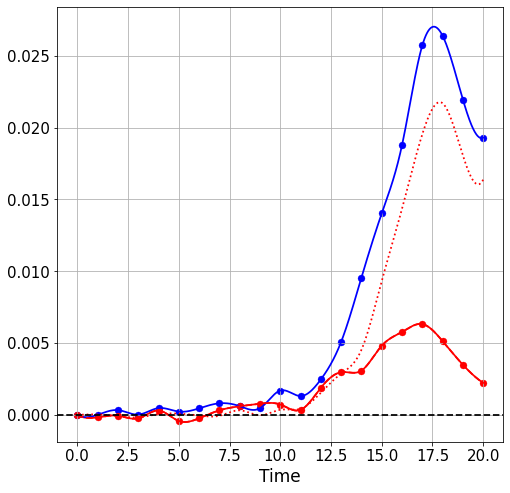

In [420]:
from scipy.interpolate import make_interp_spline
start = 0
stop  = 21
times = list(range(start,stop))
plt.figure(figsize=(8,8))



    
    
    

# Interpolating in between points for smoother line
X_Y_Spline = make_interp_spline(times,JdotEnew[start:stop])
X_ = np.linspace(np.min(times), np.max(times), 1000)
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_, color = 'r', label = 'JdotE (smoothed)')


X_Y_Spline = make_interp_spline(times,np.abs(div_Snew[start:stop]))
X_ = np.linspace(np.min(times), np.max(times), 1000)
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_, color = 'b', label = 'Div_S (smoothed)')

X_Y_Spline = make_interp_spline(times,JdotEenew[start:stop])
X_ = np.linspace(np.min(times), np.max(times), 1000)
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_, color = 'r', linestyle='dotted', label = 'JdotEe (smoothed)')

X_Y_Spline = make_interp_spline(times,JdotEinew[start:stop])
X_ = np.linspace(np.min(times), np.max(times), 1000)
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_, color = 'r', linestyle='dashed', label = 'JdotEi (smoothed)')

X_Y_Spline = make_interp_spline(times,dudtnew[start:stop])
X_ = np.linspace(np.min(times), np.max(times), 1000)
Y_ = X_Y_Spline(X_)
#plt.plot(X_,Y_, color = 'k', label = 'dudt (smoothed)')



#X_Y_Spline = make_interp_spline(times,div_Sx[start:stop])
#X_ = np.linspace(np.min(times), np.max(times), 1000)
#Y_ = X_Y_Spline(X_)
#plt.plot(X_,Y_, color = 'c', label = 'Div_Sx (smoothed)')

#X_Y_Spline = make_interp_spline(times,div_Sz[start:stop])
#X_ = np.linspace(np.min(times), np.max(times), 1000)
#Y_ = X_Y_Spline(X_)
#plt.plot(X_,Y_, color = 'm', label = 'Div_Sz (smoothed)')




plt.scatter(times, np.abs(div_Snew[start:stop]), marker = 'o', color = 'b')
#plt.scatter(times, div_Sx[start:stop], marker = 'o', color = 'c')
#plt.scatter(times, div_Sz[start:stop], marker = 'o', color = 'm')
plt.scatter(times, JdotEnew[start:stop], marker = 'o', color = 'r')
#plt.scatter(times, dudtnew[start:stop], marker = 'o', color = 'k')


plt.axhline(y = 0, color = 'k', linestyle = '--')#, label = 'upstream B0')



plt.yscale('linear')
plt.grid(True)
plt.xlabel('Time', fontsize = 17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.ylabel('E Rx', fontsize=17)
#plt.legend(loc='upper left', prop={'size': 18})

(array([-60., -40., -20.,   0.,  20.,  40.,  60.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

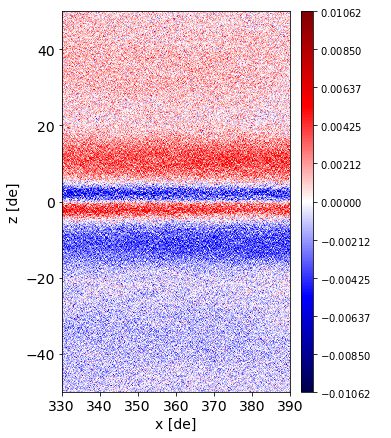

In [172]:

run = run1 #run1 or run4

vf = viscid.load_file(run, force_reload=True)

t = 10

vf.activate_time(t)
a = vf["hx_fc"]
x,y,z = a.crds.get_crds_nc()
dx,dy,dz = a.crds.get_dx()
    
# E&B Fields
Ex, Ey, Ez = vf["ex_ec"], vf["ey_ec"], vf["ez_ec"] 
Bx, By, Bz = vf["hx_fc"], vf["hy_fc"], vf["hz_fc"]
#E = Efact*make_vec(Ex,Ey,Ez)
E = make_vec(Ex,Ey,Ez)

B = make_vec(Bx,By,Bz)

B_mag = (Bx**2 + By**2 + Bz**2)**0.5
E_mag = (Ex**2 + Ey**2 + Ez**2)**0.5

EPar = (Ex*Bx + Ey*By * Ez*Bz) / B_mag
EPerp = E_mag - EPar

# Current densities
jx_e, jy_e, jz_e = vf["jx_nc_e"], vf["jy_nc_e"], vf["jz_nc_e"]
jx_i, jy_i, jz_i = vf["jx_nc_i"], vf["jy_nc_i"], vf["jz_nc_i"]
je = make_vec(jx_e,jy_e,jz_e)
ji = make_vec(jx_i,jy_i,jz_i)

JePar = (jx_e*Bx + jy_e*By + jz_e*Bz)/B_mag
JiPar = (jx_i*Bx + jy_i*By + jz_i*Bz)/B_mag


J_mag = ((jx_e + jx_i)**2 + (jy_e + jy_i)**2 + (jz_e + jz_i)**2)**0.5
Je_mag = (jx_e**2 + jy_e**2 + jz_e**2)**0.5

JedotE = jx_e*Ex + jy_e*Ey + jz_e*Ez
JidotE = jx_i*Ex + jy_i*Ey + jz_i*Ez

JedotE_Par = JePar*EPar
JidotE_Par = JiPar*EPar

JedotE_Perp = JedotE - JePar*EPar
JidotE_Perp = JidotE - JiPar*EPar



JPar = ((jx_e+jx_i)*Bx + (jy_e+jy_i)*By + (jz_e+jz_i)*Bz)/B_mag
#JPerp = J_mag - JPar

#JePerp = Je_mag - JePar

# Velocities
vex = jx_e / vf["rho_nc_e"]
vey = jy_e / vf["rho_nc_e"]
vez = jz_e / vf["rho_nc_e"]
vix = jx_i / vf["rho_nc_i"]
viy = jy_i / vf["rho_nc_i"]
viz = jz_i / vf["rho_nc_i"]
ve = make_vec(vex,vey,vez)
vi = make_vec(vix,viy,viz)

# Non-ideal E Fields
Ex_prime = Ex  + vey*Bz - vez*By
Ey_prime = Ey  + vez*Bx - vex*Bz
Ez_prime = Ez  + vex*By - vey*Bx
E_prime = make_vec(Ex_prime, Ey_prime, Ez_prime)

JE_prime = (je['x']+ji['x'])*E_prime['x'] + (je['y']+ji['y'])*E_prime['y'] + (je['z']+ji['z'])*E_prime['z'] 
#JE_prime = (je['x'])*E_prime['x'] + (je['y'])*E_prime['y'] + (je['z'])*E_prime['z'] 

# Field Energy Densities (not sure what to put as factor, so can't compare magnitudes)
uE = (Ex**2 + Ey**2 + Ez**2)/2
uB = (Bx**2 + By**2 + Bz**2)/2
    # ## Maybe 

# Number densities (related to charge density parameter)
ne, ni = vf["ne = -rho_nc_e"], vf["ni = rho_nc_i"]

nq = "nq = rho_nc_e + rho_nc_i"

    
uke = ne*(vex**2 + vey**2 + vez**2)/2
    

# Temperatures
# Divide by three?  or no?
Texx, Teyy, Tezz, Texy, Texz, Teyz = vf["txx_nc_e"], vf["tyy_nc_e"], vf["tzz_nc_e"], vf["txy_nc_e"], vf["tzx_nc_e"], vf["tyz_nc_e"]
Tixx, Tiyy, Tizz, Tixy, Tixz, Tiyz = vf["txx_nc_i"], vf["tyy_nc_i"], vf["tzz_nc_i"], vf["txy_nc_i"], vf["tzx_nc_i"], vf["tyz_nc_i"]

Tee = make_vec(Texx, Teyy, Tezz) #  IMPORTANT NOTE: These are not really vector components...
Tii = make_vec(Tixx, Tiyy, Tizz) #           .....they are diagonal terms in temp tensors

Te = (vf["txx_nc_e"] + vf["tyy_nc_e"] + vf["tzz_nc_e"])/3
Ti = (vf["txx_nc_i"] + vf["tyy_nc_i"] + vf["tzz_nc_i"])/3

#Careful when calculating T_Perp.  You'll get negative vals if the factor of 1/3 is only on Te

Te_Par = (Texx*(Bx**2) +Teyy*(By**2) + Tezz*(Bz**2) + 2*Texy*Bx*By + 2*Texz*Bx*Bz + 2*Teyz*By*Bz) / B_mag**2 
Te_Perp = (Texx + Teyy + Tezz - Te_Par)/2 
Te_ParPerp = Te_Par/Te_Perp - 1

Ti_Par = (Tixx*(Bx**2) +Tiyy*(By**2) + Tizz*(Bz**2) + 2*Tixy*Bx*By + 2*Tixz*Bx*Bz + 2*Tiyz*By*Bz) / B_mag**2 
Ti_Perp = (Tixx + Tiyy + Tizz - Ti_Par)/2 
Ti_ParPerp = Ti_Par/Ti_Perp - 1












# Poynting Flux
Sx = (Ey*Bz - Ez*By)#/mu0
Sy = (Ez*Bx - Ex*Bz)#/mu0
Sz = (Ex*By - Ey*Bx)#/mu0
#S = Efact*Bfact*make_vec(Sx,Sy,Sz)
S = make_vec(Sx,Sy,Sz)




# Kinetic Energy Flux
#
#
 #

 # J.E Contributions
JEx = (jx_e + jx_i)*Ex
JEy = (jy_e + jy_i)*Ey
JEz = (jz_e + jz_i)*Ez
JE = JEx + JEy + JEz

JEe = jx_e*Ex + jy_e*Ey + jz_e*Ez
JEi = jx_i*Ex + jy_i*Ey + jz_i*Ez



  #Poynting's Theorem Terms
#divS = (Sx[2:,:,1:-1] - Sx[:-2,:,1:-1]) / (2*dx[0])  + (Sz[1:-1,:,2:] - Sz[1:-1,:,:-2]) / (2*dz[0])
#JE = (JEx[1:-1,:,1:-1]) + (JEy[1:-1,:,1:-1]) + (JEz[1:-1,:,1:-1])
#JE_alt = JEx + JEy + JEz
#dudt = -JE - divS




plt.figure(figsize=(7,7))
#vlt.plot(Te_ParPerp,cmap = "seismic",symmetric=True,clim=(0,2), cbarlabel = " ", selection ="x=330f:410f, z=-30f:30f ")

vlt.plot(Ez,cmap = "seismic",symmetric=True, cbarlabel = " ",selection ="x=330f:390f, z=-50f:50f ")
#plt.ylim(-60,60)
#plt.xlim(300,500)

fnt=14
plt.xlabel("x [de]", fontsize=fnt)
plt.ylabel("z [de]", fontsize=fnt)
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)



(array([-60., -40., -20.,   0.,  20.,  40.,  60.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

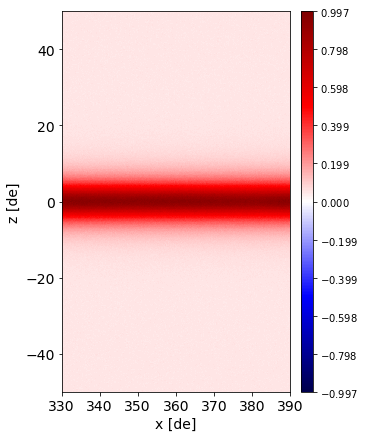

In [174]:
plt.figure(figsize=(7,7))
#vlt.plot(Te_ParPerp,cmap = "seismic",symmetric=True,clim=(0,2), cbarlabel = " ", selection ="x=330f:410f, z=-30f:30f ")

vlt.plot(ne,cmap = "seismic",symmetric=True, cbarlabel = " ",selection ="x=330f:390f, z=-50f:50f ")
#plt.ylim(-60,60)
#plt.xlim(300,500)

fnt=14
plt.xlabel("x [de]", fontsize=fnt)
plt.ylabel("z [de]", fontsize=fnt)
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)



(array([-30., -20., -10.,   0.,  10.,  20.,  30.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

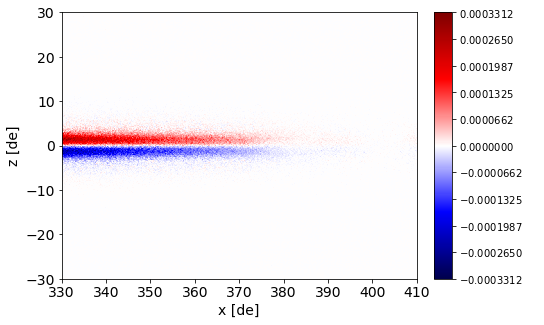

In [510]:
plt.figure(figsize=(7,7))
#vlt.plot(Te_ParPerp,cmap = "seismic",symmetric=True,clim=(0,2), cbarlabel = " ", selection ="x=330f:410f, z=-30f:30f ")

vlt.plot(-jx_e*By,cmap = "seismic",symmetric=True, cbarlabel = " ",selection ="x=330f:410f, z=-30f:30f ")
#plt.ylim(-60,60)
#plt.xlim(300,500)

fnt=14
plt.xlabel("x [de]", fontsize=fnt)
plt.ylabel("z [de]", fontsize=fnt)
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)


In [608]:
#setscale=12*max(ve)
setscale = 10*max(S)

(array([-20., -15., -10.,  -5.,   0.,   5.,  10.,  15.,  20.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

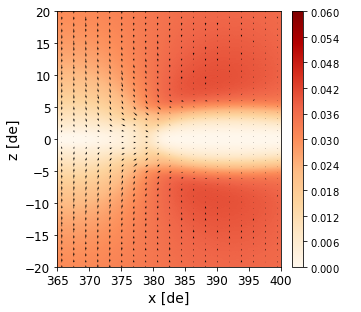

In [613]:
# Vector Plotting


cut = 'x=::6, z=::3'
step = 2

fnt = 12
plt.figure(figsize=(4.7,4.7))
vlt.plot((Bfact**2)*uB/(4*np.pi), clim=(0,0.06),cmap = "OrRd",cbarlabel= " ")
#vlt.plot((Bfact**2)*uB, cmap = "OrRd",cbarlabel= " ")

#vlt.plot(Tifact*Ti_Perp, cmap = "OrRd",cbarlabel= " ", clim=(0,470))


#vlt.plot(E_prime['y'], cmap = "seismic", symmetric=True,cbarlabel= " ")

_S_ = vlt.plot2d_quiver(S[cut],step = step ,scale = setscale, linewidth=0, color = 'k')
#_E_ = vlt.plot2d_quiver(E[cut],step = step ,scale = 12*max(E), linewidth=50, color = 'r')
#_B_ = vlt.plot2d_quiver(B[cut],step = step ,scale = 24*max(B), linewidth=50, color = 'b')
#_ve_ = vlt.plot2d_quiver(ve[cut],step = step ,scale = 12*max(ve), linewidth=50, color = 'k')
#_ve_ = vlt.plot2d_quiver(ve[cut],step = step ,scale = setscale, linewidth=50, color = 'k')
#_vi_ = vlt.plot2d_quiver(vi[cut],step = step ,scale = 12*max(ve), linewidth=50, color = 'r')


plt.axis("image")
plt.xlim(365,400)
plt.ylim(-20,20)
plt.xlabel("x [de]", fontsize=fnt+2)
plt.ylabel("z [de]", fontsize=fnt+2)


plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)

#vlt.auto_adjust_subplots()

(array([-20., -15., -10.,  -5.,   0.,   5.,  10.,  15.,  20.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

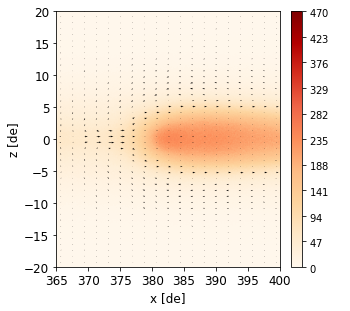

In [598]:
# Vector Plotting


cut = 'x=::6, z=::3'
step = 2

fnt = 12
plt.figure(figsize=(4.7,4.7))
#vlt.plot(uB/(4*np.pi), cmap = "OrRd",cbarlabel= " ")
#vlt.plot(JidotE_Perp, cmap = "seismic",symmetric=True,cbarlabel= " ")


vlt.plot(Tifact*Ti, cmap = "OrRd",clim = (0,470),cbarlabel= " ")

#vlt.plot(Te_Perp, cmap = "seismic",clim=(0,0.1),symmetric=True,cbarlabel= " ")


#vlt.plot(E_prime['y'], cmap = "seismic", symmetric=True,cbarlabel= " ")

#_S_ = vlt.plot2d_quiver(S[cut],step = step ,scale = 10*max(S), linewidth=0, color = 'k')
#_E_ = vlt.plot2d_quiver(E[cut],step = step ,scale = 12*max(E), linewidth=50, color = 'r')
#_B_ = vlt.plot2d_quiver(B[cut],step = step ,scale = 24*max(B), linewidth=50, color = 'b')
_ve_ = vlt.plot2d_quiver(ve[cut],step = step ,scale = setscale, linewidth=50, color = 'k')
#_ve_ = vlt.plot2d_quiver(ve[cut],step = step ,scale = 12*max(ve), linewidth=50, color = 'b')
#_vi_ = vlt.plot2d_quiver(vi[cut],step = step ,scale = 12*max(ve), linewidth=50, color = 'r')


plt.axis("image")
plt.xlim(365,400)
plt.ylim(-20,20)
plt.xlabel("x [de]", fontsize=fnt)
plt.ylabel("z [de]", fontsize=fnt)


plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)

#vlt.auto_adjust_subplots()

(array([-6., -4., -2.,  0.,  2.,  4.,  6.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

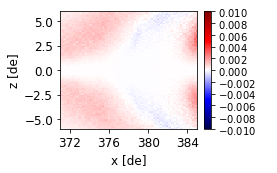

In [140]:
# Vector Plotting (closeup)


cut = 'x=::4, z=::2'
step = 2

fnt = 12
plt.figure(figsize=(2.7,2.7))
#vlt.plot(uB/(4*np.pi), cmap = "OrRd",cbarlabel= " ")
vlt.plot(JEfact*JidotE_Par,clim=(0,0.01), cmap = "seismic",symmetric = True,cbarlabel= " ")
#vlt.plot(jx_e, cmap = "seismic",symmetric = True,cbarlabel= " ")


#vlt.plot(E_prime['y'], cmap = "seismic", symmetric=True,cbarlabel= " ")

#_S_ = vlt.plot2d_quiver(S[cut],step = step ,scale = 10*max(S), linewidth=0, color = 'k')
#_E_ = vlt.plot2d_quiver(E[cut],step = step ,scale = 12*max(E), linewidth=50, color = 'k')
#_B_ = vlt.plot2d_quiver(B[cut],step = step ,scale = 24*max(B), linewidth=50, color = 'b')
#_ve_ = vlt.plot2d_quiver(ve[cut],step = step ,scale = 12*max(ve), linewidth=50, color = 'k')
#_ve_ = vlt.plot2d_quiver(ve[cut],step = step ,scale = 12*max(ve), linewidth=50, color = 'b')
#_vi_ = vlt.plot2d_quiver(vi[cut],step = step ,scale = 12*max(ve), linewidth=50, color = 'r')


plt.axis("image")
plt.xlim(371,385)
plt.ylim(-6,6)
plt.xlabel("x [de]", fontsize=fnt)
plt.ylabel("z [de]", fontsize=fnt)


plt.xticks(np.arange(372,386, 4),fontsize=fnt)
plt.yticks(fontsize=fnt)
#vlt.tighten()

#vlt.auto_adjust_subplots()

In [ ]:
# Vector Plotting

plt.figure(figsize=(10, 10))


vlt.plot(E_prime['y'], cmap = "seismic", symmetric = "True",cbarlabel="S")
Q = vlt.plot2d_quiver(S['x=::8, z=::4'],step = 2 ,scale = 30000, linewidth=500)
plt.xlim(310,400)
plt.ylim(-25,25)
fnt = 20
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)
plt.xlabel('x', fontsize=fnt)
plt.ylabel('z', fontsize=fnt)
vlt.auto_adjust_subplots()

In [231]:
#fig, ax = plt.subplots(3,1,figsize=(20,20))

#vlt.plot(S['x'], ax = ax[0],cmap = "seismic", symmetric = "True",cbarlabel="Ey_prime", selection = "x=700f:850f, z=-40f:40f")
#vlt.plot(S['y'], ax = ax[1],cmap = "seismic", symmetric = "True",cbarlabel="Ey_prime", selection = "x=700f:850f, z=-40f:40f")
#vlt.plot(S['z'], ax = ax[2],cmap = "seismic", symmetric = "True",cbarlabel="Ey_prime", selection = "x=700f:850f, z=-40f:40f")

In [21]:
run = run1

E8, B8, S8, ve8, E8_prime, du8, ne8 = Activate(run,8)
E9, B9, S9, ve9, E9_prime, du9, ne9 = Activate(run,9)
E10, B10, S10, ve10, E10_prime, du10, ne10 = Activate(run,10)
E11, B11, S11, ve11, E11_prime, du11, ne11 = Activate(run,11)
E12, B12, S12, ve12, E12_prime, du12, ne12 = Activate(run,12)
E13, B13, S13, ve13, E13_prime, du13, ne13 = Activate(run,13)
E14, B14, S14, ve14, E14_prime, du14, ne14 = Activate(run,14)
E15, B15, S15, ve15, E15_prime, du15, ne15 = Activate(run,15)
E16, B16, S16, ve16, E16_prime, du16, ne16 = Activate(run,16)
E17, B17, S17, ve17, E17_prime, du17, ne17 = Activate(run,17)
E18, B18, S18, ve18, E18_prime, du18, ne18 = Activate(run,18)
E19, B19, S19, ve19, E19_prime, du19, ne19 = Activate(run,19)
E20, B20, S20, ve20, E20_prime, du20, ne20 = Activate(run,20)

In [526]:
E, B, S, ve, E_prime, du, ne = Activate(run,0)


/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:523: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad(masknan)
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:527: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad('y')
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:214: MatplotlibDeprecationWarning: 
The get_rows_columns function was depreca

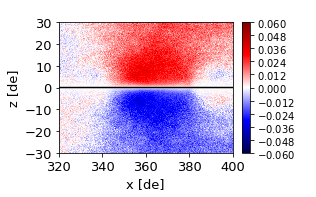

In [83]:
# Make 1D cuts to look at data along cut
# This cell makes 2 lines: a horizontal line from pt0 to pt1 and a vert line from pt2 to pt3
# an idea is to use this to study parameters along the inflow and outflow axes intersecting at the z-point

pt0 = (320, 0, 0) # x,y,z coords for beginning and end of a line in domain 
pt1 = (400, 0, 0)

#pt0 = (340, 0, 4) # x,y,z coords for beginning and end of a line in domain 
#pt1 = (390, 0, 4)


pt2 = (pts1[t], 10, 200) # x,y,z coords for beginning and end of a line in domain (using pts#[t] keeps the vert line intersecting the center of x-point based on pre-defined pts)
pt3 = (pts1[t], 10, -200)
npts = 100000         # number of measurements along line between pt0 and pt1

lin_h = np.linspace(pt0[0], pt1[0], npts)
lin_v = np.linspace(pt2[2], pt3[2], npts)

seeds_h = viscid.seed.Line(pt0, pt1, npts)
seeds_v = viscid.seed.Line(pt2, pt3, npts)

seed_pts_v = seeds_v.get_points()
seed_pts_h = seeds_h.get_points()


fnt = 13 #axis fontsizes


# Make colorplot
plt.figure(figsize=(4.5,4.5))
plt.subplot(1,1,1)
vlt.plot(Efact*Bfact*E['y']*B['x'], clim = (0,0.06),cmap = "seismic", symmetric = True, title = ' ', cbarlabel=" ")
plt.axis("image")
plt.xlim(320,400)
plt.ylim(-30,30)
plt.xlabel("x [de]", fontsize=fnt)
plt.ylabel("z [de]", fontsize=fnt)

plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)




plt.plot(seed_pts_h[0,:], seed_pts_h[2,:], color = 'k', lw = 1.5)
#plt.plot(seed_pts_v[0,:], seed_pts_v[2,:], color = 'k')





vlt.tighten() #No idea what this does

(array([-0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,  0.06]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

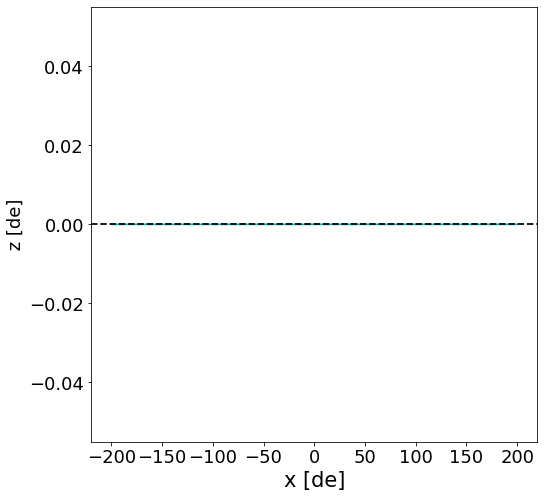

In [531]:
#plt.plot(lin_v, viscid.interp_trilin(ne*Tee['x'], seeds_v), color = 'k')
#plt.plot(lin_v, viscid.interp_trilin(ne*Tee['z'], seeds_v), color = 'r')
#plt.plot(lin_v, viscid.interp_trilin(ne*Tee['y'], seeds_v), color = 'g')



#plt.plot(lin_v, viscid.interp_trilin((B['x']**2 + B['y']**2 + B['z']**2), seeds_v), color = 'b')
plt.plot(lin_v, viscid.interp_trilin((E['y']**2 ), seeds_v), color = 'c')


plt.axhline(y = 0, color = 'k', linestyle = '--')#, label = 'upstream B0')



fnt = 18
plt.xlabel("x [de]", fontsize = fnt+3)
plt.ylabel(" z [de] ",fontsize = fnt)
#plt.xlim(-30,30)
#plt.ylim(,0.001)

plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)



In [53]:
# For plotting same variable over same cut for multiple timesteps (requires defining seperate fields for all timesteps)

#flds = [E12,E13,E14,E15,E16,E17,E18]
#flds_ = []
#fld_labs = ["12", "13", "14", "15", "16","17","18"]
#colors = ["k", "b", "c", "lightseagreen","g", 'orangered', 'r']

#for i in range(7):
#    flds_.append(viscid.interp_trilin(flds[i], seeds_h))

#fig, ax = plt.subplots(1,1,figsize=(10,10))

#for i in range(len(flds)):
#    plt.plot(lin_h, flds_[i]['y'], label = fld_labs[i], color = colors[i])
    


(array([-0.03 , -0.025, -0.02 , -0.015, -0.01 , -0.005,  0.   ,  0.005,
         0.01 ,  0.015,  0.02 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

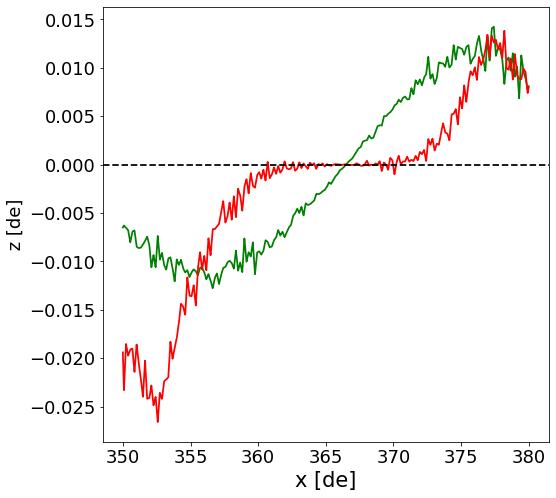

In [54]:
plt.plot(lin_h, viscid.interp_trilin(Efact*Bfact*E['y']*B['z'], seeds_h), color = 'g')
plt.plot(lin_h, viscid.interp_trilin(-Efact*Bfact*E['z']*B['y'], seeds_h), color = 'r')
plt.axhline(y = 0, color = 'k', linestyle = '--')#, label = 'upstream B0')



fnt = 18
plt.xlabel("x [de]", fontsize = fnt+3)
plt.ylabel(" z [de] ",fontsize = fnt)
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)



(array([-0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

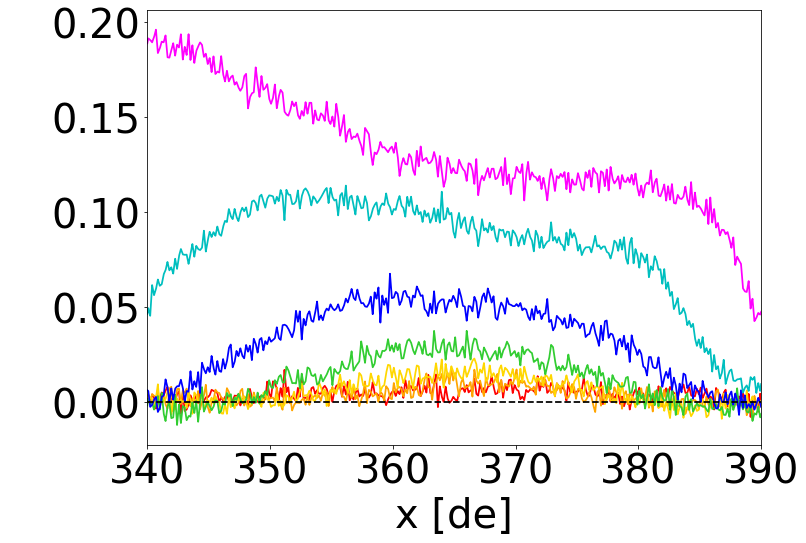

In [81]:
flds = [S10, S11, S12, S13, S14, S15, S16, S17, S18, S19, S20]
Bflds = [B10, B11, B12, B13, B14, B15, B16, B17, B18, B19, B20]
Eflds = [E10, E11, E12, E13, E14, E15, E16, E17, E18, E19, E20]
vflds = [ve10, ve11, ve12,ve13, ve14, ve15, ve16, ve17, ve18, ve19, ve20]
Epflds = [E10_prime,E11_prime,E12_prime, E13_prime, E14_prime, E15_prime, E16_prime, E17_prime, E18_prime, E19_prime, E20_prime]
#duflds = [du10, du11, du12, du13, du14, du15, du16, du17, du18, du19, du20] #this wasnt very helpful
#neflds = [ne8, ne9, ne10, ne11, ne12, ne13, ne14, ne15, ne16, ne17, ne18, ne19, ne20] #this wasnt very helpful
#neflds = [ne10, ne11, ne12, ne13, ne14, ne15, ne16, ne17, ne18, ne19, ne20] #this wasnt very helpful


#labels = ['t = 8', 't = 9', 't = 10', 't = 11', 't = 12', 't = 13', 't = 14', 't = 15', 't = 16', 't = 17', 't = 18', 't = 19', 't = 20'] 
labels = ['t = 10', 't = 11', 't = 12', 't = 13', 't = 14', 't = 15', 't = 16', 't = 17', 't = 18', 't = 19', 't = 20'] 

fldv = []
fldh = []
colors=['k', 'brown', 'red', 'orange', 'gold', 'limegreen', 'blue', 'c', 'magenta', 'indigo','crimson', 'slategrey', 'royalblue']




#plt.plot(lin_h, viscid.interp_trilin(B12['z'], seeds_h))
#plt.plot(lin_h, viscid.interp_trilin(B13['z'], seeds_h))


n = 1
fig, ax = plt.subplots(n,1,figsize=(11,8))

for i in range(2,9):
    #plt.plot(lin_h, viscid.interp_trilin(Efact*vflds[i]['x']*Bflds[i]['z'], seeds_h), color = colors[i], label = labels[i] )
    #plt.plot(lin_h, viscid.interp_trilin(-vflds[i]['z']*Bflds[i]['x'], seeds_h), color = colors[i], label = labels[i] )
    
    #plt.plot(lin_h, viscid.interp_trilin(flds[i]['x'], seeds_h), color = colors[i], label = labels[i] )
    


    #plt.axhline(y = 1, color='k', linestyle='--')
    #plt.axhline(y = -1, color='k', linestyle='--')

    plt.plot(lin_h, viscid.interp_trilin(Efact*Eflds[i]['y'], seeds_h), color = colors[i], label = labels[i] )
    #plt.plot(lin_h, viscid.interp_trilin(vflds[i]['x']*Bflds[i]['z'], seeds_h), color = colors[i], label = labels[i] )
    #plt.plot(viscid.interp_trilin((Bflds[i]['x']**2 + Bflds[i]['y']**2 + Bflds[i]['z']**2)/2, seeds_v), lin_v, color = colors[i], label = labels[i] )
    #plt.plot(lin_h,viscid.interp_trilin(Epflds[i]['y'], seeds_h), color = colors[i], label = labels[i] )
    #plt.plot(viscid.interp_trilin(-vflds[i]['x']*Bflds[i]['y'], seeds_v), lin_v, color = colors[i], label = labels[i] )



plt.axhline(y = 0, color = 'k', linestyle = '--')#, label = 'upstream B0')
    
#plt.axhline(y = 1, color = 'k', linestyle = '--')#, label = 'upstream B0')
#plt.axhline(y = -1, color = 'k', linestyle = '--')#, label = 'upstream B0')

#plt.axvline(x = pts1[18], color = 'k', linestyle = 'dotted', lw = 2)#, label = 'upstream B0')

i=6

#plt.plot(lin_h, viscid.interp_trilin(duflds[i], seeds_h), color = 'g')#, label = labels[i] )


#plt.plot(lin_h, viscid.interp_trilin(Eflds[i]['x']*Bflds[i]['y'], seeds_h), color = 'g')#, label = labels[i] )
#plt.plot(lin_h, viscid.interp_trilin(-Eflds[i]['y']*Bflds[i]['x'], seeds_h), color = 'r')#, label = labels[i] )
#plt.axhline(y=0, linestyle = "--", color="k", linewidth=1.5)

fnt=40
plt.xlabel("x [de]", fontsize = fnt)
plt.ylabel(" ",fontsize = fnt)
plt.xlim(340,390)
#plt.ylim(340,390)
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)

#plt.legend(prop={'size': 45},loc=(1.02,0-.2))

(array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

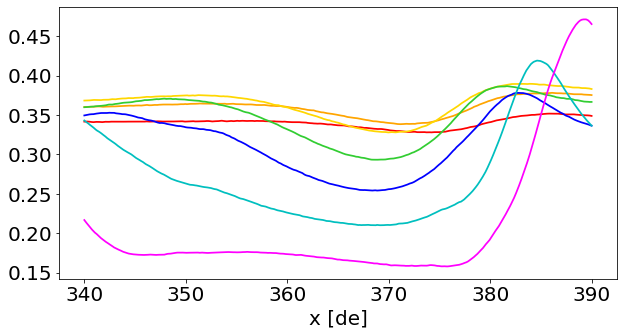

In [18]:
n = 1
fig, ax = plt.subplots(n,1,figsize=(10,n*5))



for i in range(2,9):
    #plt.plot(lin_h, viscid.interp_trilin(flds[i]['z']/0.5, seeds_h), color = colors[i], label = labels[i] )
    #plt.plot(lin_h, viscid.interp_trilin(Efact*Epflds[i]['y'], seeds_h), color = colors[i], label = labels[i] )
    #plt.plot(lin_h, viscid.interp_trilin(-Efact*vflds[i]['z']*Bflds[i]['x'], seeds_h), color = colors[i], label = labels[i] )
    #plt.plot(lin_h, viscid.interp_trilin(vflds[i]['z'], seeds_h), color = colors[i], label = labels[i] )
    plt.plot(lin_h, viscid.interp_trilin(Bflds[i]['x'], seeds_h), color = colors[i], label = labels[i])


    
#plt.axhline(y = 1, color = 'k', linestyle = '--')#, label = 'upstream B0')
#plt.axhline(y = -1, color = 'k', linestyle = '--')#, label = 'upstream B0')

#plt.axvline(x = pts1[18], color = 'k', linestyle = 'dotted', lw = 2)#, label = 'upstream B0')
fnt = 20
plt.xlabel("x [de]", fontsize = fnt)
#plt.ylabel("-VzBx",fontsize = 15)
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)

#plt.legend(prop={'size': 30},loc=(1.02,0.6))

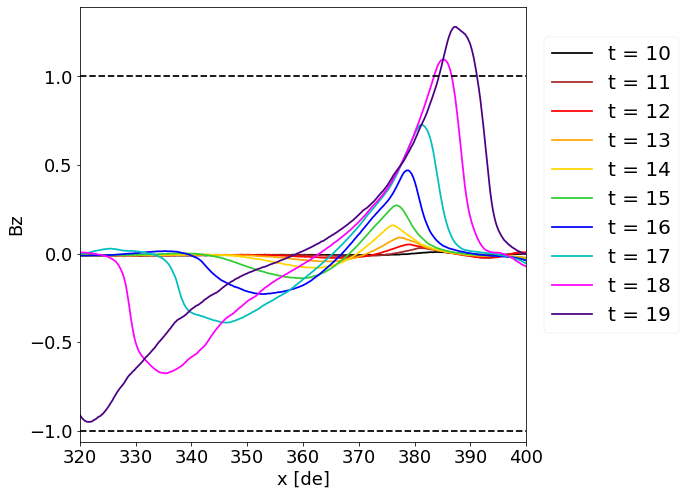

In [85]:
Bflds = [B10, B11, B12, B13, B14, B15, B16, B17, B18, B19, B20]
labels = ['t = 10', 't = 11', 't = 12', 't = 13', 't = 14', 't = 15', 't = 16', 't = 17', 't = 18', 't = 19', 't = 20'] 
fldv = []
fldh = []
colors=['k', 'brown', 'red', 'orange', 'gold', 'limegreen', 'blue', 'c', 'magenta', 'indigo','crimson', 'slategrey', 'royalblue']



fld = B12['z']


fld_label = "Bz"
n = 1


#plt.plot(lin_h, viscid.interp_trilin(B12['z'], seeds_h))
#plt.plot(lin_h, viscid.interp_trilin(B13['z'], seeds_h))

i=0
for i in range(0,10):
    plt.plot(lin_h, viscid.interp_trilin(Bfact*Bflds[i]['z'], seeds_h), color = colors[i], label = labels[i] )

    
plt.axhline(y = 1, color = 'k', linestyle = '--')#, label = 'upstream B0')
plt.axhline(y = -1, color = 'k', linestyle = '--')#, label = 'upstream B0')

#plt.axvline(x = pts1[18], color = 'k', linestyle = 'dotted', lw = 2)#, label = 'upstream B0')
fnt = 18
plt.xlabel("x [de]", fontsize =fnt)
plt.ylabel("Bz",fontsize = fnt)
plt.xlim(320,400)
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)

plt.legend(prop={'size': 20},loc=(1.04,0.25))

In [48]:
tm = 4
plt.plot(lin_h, viscid.interp_trilin(Eflds[tm]['x']*Bflds[tm]['y'], seeds_h), color = 'g', label = 'ExBy' )
plt.plot(lin_h, viscid.interp_trilin(-Eflds[tm]['y']*Bflds[tm]['x'], seeds_h), color = 'r', label = '-EyBx')

plt.xlabel("x [de]", fontsize = 15)
#plt.ylabel("EyBz",fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(prop={'size': 20},loc=(0.7,0.5))

NameError: name 'Eflds' is not defined